### Student Information
Name: 謝芝瑜

Student ID: 111065503

GitHub ID:  Judy-Hsieh

Kaggle name: Zhiyu_Judy

Kaggle private scoreboard snapshot:

[Snapshot](img/pic0.png)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the [DM2022-Lab2-master Repo](https://github.com/keziatamus/DM2022-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm2022-isa5810-lab2-homework) regarding Emotion Recognition on Twitter by this link https://www.kaggle.com/t/2b0d14a829f340bc88d2660dc602d4bd. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Nov. 22th 11:59 pm, Tuesday)_. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 25th 11:59 pm, Friday)__. 

## 1. First:
https://github.com/Judy-Hsieh/DM2022-Lab2-Master.git

## 2. Competition:
- dataset: 
    - crawled from Twitter, tweets are labeled with emotion by some specific hashtags in the original text. 
    - 8 classes (or say emotions): 
        - anger, anticipation, disgust, fear, sadness, surprise, trust, and joy.
- clean the data by doing some pre-processing.
- Apply feature engineering or any other data mining technique you have or haven't learned in the Data Mining course. 
- The final goal is to learn a model that is able to predict the emotion behind each tweet.
- evaluation:
    - comparing your Submission CSV to the ground truth Solution CSV 
    - with respect the chosen the Mean F1 Score

### Pre-processing

### 1.1 Load data
- `tweets_DM.json` - Raw data from Twitter
- `emotion.csv` - Lists the emotion labels per tweet_id
- `data_identification.csv` - A file that identifies membership of training or testing set per tweet_id. Note that you won´t be provided with the labels for the testing set, but you will have to predict for these when you make your submission.

In [23]:
import pandas as pd
import json
import numpy as np
import helpers.data_mining_helpers as dmh
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [24]:
text_list = []
id_list = []
with open("./data/tweets_DM.json","r")as f :
    json_list = f.readlines()
    for data_json in json_list:
        data = json.loads(data_json)
        text_list.append(''.join(data['_source']['tweet']['text']))
        id_list.append(data['_source']['tweet']['tweet_id'])

In [25]:
data_tweet = {"tweet_id": id_list,"text": text_list}
data_tweet = pd.DataFrame(data_tweet)

In [26]:
data_identification = pd.read_csv("./data/data_identification.csv", sep=",")
data_emotions = pd.read_csv("./data/emotion.csv",sep=",")

### 1.2 check null

In [27]:
data_tweet.isnull().apply(lambda x: dmh.check_missing_values(x))

,tweet_id,text
0,The amoung of missing records is:,The amoung of missing records is:
1,0,0


In [28]:
data_identification.isnull().apply(lambda x: dmh.check_missing_values(x))

,tweet_id,identification
0,The amoung of missing records is:,The amoung of missing records is:
1,0,0


In [29]:
data_emotions.isnull().apply(lambda x: dmh.check_missing_values(x))

,tweet_id,emotion
0,The amoung of missing records is:,The amoung of missing records is:
1,0,0


### 1.3 Tidy up datasets

Load data_identification, merge with tweet.json

In [30]:
df = pd.merge(data_identification, data_tweet)
df.head()

,tweet_id,identification,text
0,0x28cc61,test,@Habbo I've seen two separate colours of the e...
1,0x29e452,train,Huge Respect🖒 @JohnnyVegasReal talking about l...
2,0x2b3819,train,Yoooo we hit all our monthly goals with the ne...
3,0x2db41f,test,@FoxNews @KellyannePolls No serious self respe...
4,0x2a2acc,train,@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...


Seperate training & testing data

In [31]:
test_df = df[df['identification'] == 'test']
train_df = df[df['identification'] == 'train']

Merge training data with emotion label

In [32]:
train_df = pd.merge(train_df, data_emotions)
train_df.head()

,tweet_id,identification,text,emotion
0,0x29e452,train,Huge Respect🖒 @JohnnyVegasReal talking about l...,joy
1,0x2b3819,train,Yoooo we hit all our monthly goals with the ne...,joy
2,0x2a2acc,train,@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...,trust
3,0x2a8830,train,Come join @ambushman27 on #PUBG while he striv...,joy
4,0x20b21d,train,@fanshixieen2014 Blessings!My #strength little...,anticipation


In [33]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (1455563, 4)
Shape of Testing df:  (411972, 3)


### 1.4 Feature Engineering

#### one-hot

In [35]:
from sklearn.preprocessing import LabelEncoder

def label_encode(le, labels):
    enc = le.transform(labels)
    return tf.keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

In [39]:
y_train = train_df['emotion']

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
y_train = label_encode(label_encoder, y_train)
y_train

check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']

## Before convert
y_train[0:4]:
 1328366         disgust
675094              joy
1300696             joy
747488     anticipation
Name: emotion, dtype: object

y_train.shape:  (1455563,)


C:\Users\Judy\AppData\Local\Temp\ipykernel_13056\2245032200.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print('y_train[0:4]:\n', y_train[0:4])


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

#### Tokenizer

In [42]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

def preprocess_fn(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### 1.5 Setup Training & Validation set
- data_identification (1867535)
    - training set (1455563)=> provided emotions labels
        - data_emotions (1455563) 
        - train : validation = 7 : 3
    - testing set (411972)=> no labels we need to predict

Shuffle

In [34]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [ ]:
from datasets import load_dataset, Dataset

dataset = Dataset.from_dict({'text': train_df['text'], 'labels':  y_train})
dataset_test = Dataset.from_dict({'text': test_df['text']})
dataset[0]

{'text': "#BadMoms2 #DaddysHome2  Hollywood Is losing. It really has run out of new ideas. I'm not going buying this. This ain't entertaining. <LH>",
 'labels': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

In [ ]:
dataset_test[0]

{'text': 'Dunkin’ Iced Coffee + 8 Crm. Swirls  <LH>'}

Tokenize

In [43]:
tokenized_dataset = dataset.map(preprocess_fn, batched=True)
tokenized_dataset_test = dataset_test.map(preprocess_fn, batched=True)

  0%|          | 0/1456 [00:00<?, ?ba/s]

  0%|          | 0/412 [00:00<?, ?ba/s]

In [44]:
train_dataset, validation_dataset = tokenized_dataset.train_test_split(test_size=0.3).values()
train_dataset = train_dataset.shuffle(seed=42)
validation_dataset = validation_dataset.shuffle(seed=42)

In [45]:
test_dataset = tokenized_dataset_test

In [46]:
train_dataset

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1018894
})

In [47]:
validation_dataset

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 436669
})

In [48]:
test_dataset

Dataset({
    features: ['text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 411972
})

### 2. Model: BERT

In [49]:
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from transformers import AutoModelForSequenceClassification

In [ ]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

#### 2.1 Load Model

In [50]:
model= AutoModelForSequenceClassification.from_pretrained('vinai/bertweet-base',num_labels = 8)
model

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

#### 2.2 compute_metrices

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    labels = np.argmax(labels,axis=-1)
    return {
        "accuracy": accuracy_score(y_pred=predictions, y_true=labels),
        "f1": f1_score(y_pred=predictions, y_true=labels, average='macro' ),
        "precision": precision_score(y_pred=predictions, y_true=labels, average='weighted'),
        "recall": recall_score(y_pred=predictions, y_true=labels, average='weighted')
    }

In [ ]:
## clean up memory
# torch.cuda.empty_cache()

#### 2.3 Training Arguments

In [ ]:
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="ex4trainer",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    learning_rate=2e-05,
    evaluation_strategy='steps', # epoch
    eval_steps=5000,
    save_steps=5000,
    logging_steps=5000,
    dataloader_drop_last =False,
    load_best_model_at_end = True,
    metric_for_best_model = 'f1',
    weight_decay = 0.5
)

trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)
training_args

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


TrainingArguments(
_n_gpu=2,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=5000,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=True,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_metrics=False,
jit_mode_eval=False,
label_n

#### 2.4 Train

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1018894
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 63682
  Number of trainable parameters = 134906120


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
5000,0.233100,0.201167,0.640448,0.547772,0.646954,0.640448
10000,0.199400,0.191029,0.655975,0.567547,0.661239,0.655975
15000,0.192600,0.186117,0.663922,0.586225,0.664079,0.663922
20000,0.189100,0.183459,0.670130,0.591548,0.669233,0.670130
25000,0.185500,0.180568,0.675631,0.593122,0.685412,0.675631
30000,0.184300,0.180594,0.675791,0.595220,0.681640,0.675791
35000,0.175000,0.179972,0.678599,0.602121,0.678433,0.678599
40000,0.169600,0.181916,0.680788,0.602365,0.685941,0.680788
45000,0.168700,0.178147,0.682210,0.605360,0.685103,0.682210
50000,0.166700,0.178205,0.684649,0.606903,0.683971,0.684649


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436669
  Batch size = 64
Saving model checkpoint to ex4trainer/checkpoint-5000
Configuration saved in ex4trainer/checkpoint-5000/config.json
Model weights saved in ex4trainer/checkpoint-5000/pytorch_model.bin
/home/judy/miniconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForS

TrainOutput(global_step=63682, training_loss=0.1818430333808268, metrics={'train_runtime': 38535.943, 'train_samples_per_second': 52.88, 'train_steps_per_second': 1.653, 'total_flos': 1.340483588277289e+17, 'train_loss': 0.1818430333808268, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 436669
  Batch size = 64


{'eval_loss': 0.17586146295070648,
 'eval_accuracy': 0.6868657953736125,
 'eval_f1': 0.6126997204975206,
 'eval_precision': 0.6842127264134329,
 'eval_recall': 0.6868657953736125,
 'eval_runtime': 1530.1809,
 'eval_samples_per_second': 285.371,
 'eval_steps_per_second': 4.459,
 'epoch': 2.0}

#### 2.6 Save Model

In [ ]:
trainer.save_model("./ex4_saved_model")

Load Trained Model

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("ex4_saved_model")

Load Checkpoint

In [ ]:
# model = AutoModelForSequenceClassification.from_pretrained('./test_trainer/checkpoint-70000')
# model

#### 2.7 Predict and save output

In [ ]:
logits, tweet_id, metrics = trainer.predict(test_dataset)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 411972
  Batch size = 64


In [ ]:
predictions = label_decode(label_encoder, logits)

In [ ]:
len(predictions)

411972

In [ ]:
predictions[:5]

array(['joy', 'sadness', 'joy', 'joy', 'joy'], dtype=object)

In [ ]:
ans = test_df.reset_index()

In [ ]:
predictions = pd.DataFrame(predictions)
ans['pred'] = predictions
ans1 = ans[['tweet_id','pred']]
ans1 = ans1.rename(columns={
    'tweet_id':'id',
    'pred':'emotion'
})
ans1

,id,emotion
0,0x31081d,joy
1,0x2bf319,sadness
2,0x20a723,joy
3,0x347bab,joy
4,0x2d3f57,joy
...,...,...
411967,0x29ba10,joy
411968,0x23140b,joy
411969,0x366f22,joy
411970,0x200c19,trust


In [ ]:
ans1.to_csv('pre_epoch2_batch16.csv',header = True,index = False)

### 3. Evaluation (Compare with the model **Before** Fine tuning)

**Before** Fine tuning training arguments:
- per_device_train_batch_size=16,
- per_device_eval_batch_size=16,
- num_train_epochs=2,
- learning_rate=5e-05,

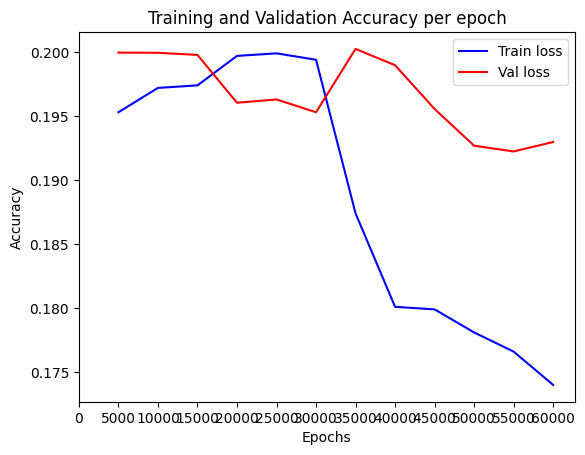

In [7]:
# ex1-plot
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

training_log_epoch = np.linspace(5000, 60001, 12)
training_log__loss = [0.195300, 0.197200, 0.197400, 0.199700, 0.199900, 0.199400, 0.187400, 0.180100, 0.179900, 0.178100, 0.176600, 0.174000]
training_log_val_loss = [0.199958, 0.199943, 0.199779, 0.196042, 0.196300, 0.195299, 0.200246, 0.198973, 0.195556, 0.192684, 0.192236, 0.192976]
plt.plot(training_log_epoch, training_log__loss, color = "blue", label = 'Train loss')
plt.plot(training_log_epoch, training_log_val_loss, color = "red", label = 'Val loss')
plt.legend()
plt.title('Training and Validation Accuracy per epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(0, 60001, 5000))
plt.show()

**After** fine tuning (using training argumaents above) <br/>
training arguments:
- per_device_train_batch_size=16,
- per_device_eval_batch_size=32,
    - give validaiton sets more batch, for faster validation
- num_train_epochs=2,
- learning_rate=2e-05
    - lower the learning rate try to make the model learn well

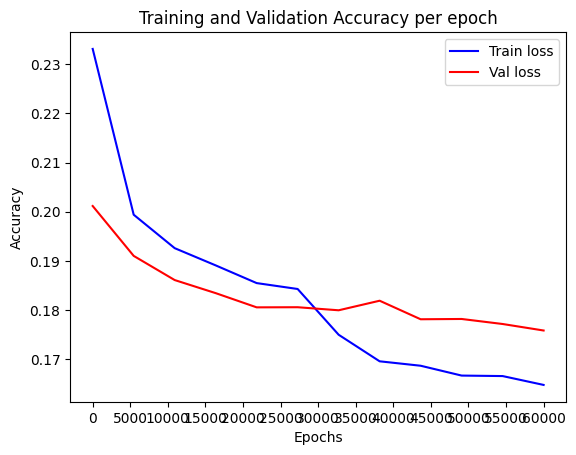

In [6]:
# ex4-plot
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

training_log_epoch = np.linspace(0, 60001, 12)
training_log__loss = [0.233100, 0.199400, 0.192600, 0.189100, 0.185500, 0.184300, 0.175000, 0.169600, 0.168700, 0.166700, 0.166600, 0.164800]
training_log_val_loss = [0.201167, 0.191029, 0.186117, 0.183459, 0.180568, 0.180594, 0.179972, 0.181916, 0.178147, 0.178205, 0.177184, 0.175861]
plt.plot(training_log_epoch, training_log__loss, color = "blue", label = 'Train loss')
plt.plot(training_log_epoch, training_log_val_loss, color = "red", label = 'Val loss')
plt.legend()
plt.title('Training and Validation Accuracy per epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(0, 60001, 5000))
plt.show()

According to the graph above, fine tuned model's validation loss have decrease obviously. <br/>
Which get higher accuracy at both Public & Private test on Kaggle.

![Imgur](https://i.imgur.com/W7MjIw1.png)